In [ ]:
#importing relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from google.colab import files
from google.colab import drive
import csv
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
diabetes_df = pd.read_csv("/content/drive/MyDrive/Final_Project/diabetic_data.csv")
diabetes_df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
diabetes_df.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [ ]:
diabetes_df.shape

(101766, 50)

### Data Pre-processing

In [ ]:
diabetes_df.replace('?', np.nan, inplace=True)

In [ ]:
#dropping all columns that have more than 50% missing values
missing_values = (diabetes_df.isnull().sum() / len(diabetes_df)) * 100
invalid_columns = missing_values[missing_values > 50].index
diabetes_df.drop(columns=invalid_columns, inplace=True)
print ("Columns with > 50% missing values have been dropped.")

Columns with > 50% missing values have been dropped.


In [ ]:
#ages are given in a range - transforming the ages to be the middle value
for i,x in enumerate(diabetes_df['age']):
    ages_array = x[1:-1].split("-")
    diabetes_df.loc[i, 'age'] = str((int(ages_array[0]) + int(ages_array[1])) / 2)
print ("The age ranges have been transformed!")

The age ranges have been transformed!


In [ ]:
#addressing outliners in the numerical columns in the dataframe -> df has been changed from diabetes to diabetic

numerical_features = diabetes_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

#calculate mean and stds for numerical columns/features
means = diabetes_df[numerical_features].mean()
stds = diabetes_df[numerical_features].std()

#the lower + upper bounds are defined using formula - mean +- (3 x stds)
lower_bounds = means - 3 * stds
upper_bounds = means + 3 * stds

#filter out rows with values outside the desired range
diabetic_df = diabetes_df.copy()
for feature in numerical_features:
    diabetic_df = diabetic_df[(diabetic_df[feature] >= lower_bounds[feature]) & (diabetic_df[feature] <= upper_bounds[feature])]

print ("Outliners in the dataset have been successfully handled")

Outliners in the dataset have been successfully handled


In [ ]:
#dropping all rows with at least one missing value
diabetic_df.dropna(inplace=True)

In [ ]:
#removing duplicates in the column - we will be looking at each counter per patient
diabetic_df.drop_duplicates(subset=['patient_nbr'], inplace=True)

In [ ]:
#creating a dict to map the original values to the binary variables
values_replaced = {'NO': 0, '<30': 1, '>30': 1}
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace(values_replaced)

print("The values have been changed!")

The values have been changed!


In [ ]:
diabetic_df.shape

(18035, 47)

In [ ]:
diabetic_df.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
20737,72848634,20377854,Caucasian,Female,65.0,2,1,1,3,MC,...,No,Steady,No,No,No,No,No,No,Yes,0
20824,73062156,20408121,Caucasian,Female,95.0,1,1,7,4,MC,...,No,No,No,No,No,No,No,No,Yes,0
21083,73731852,20542797,Caucasian,Male,75.0,1,2,7,10,MC,...,No,Steady,No,No,No,No,No,Ch,Yes,0
23879,81355914,7239654,Caucasian,Female,75.0,1,3,6,12,UN,...,No,Steady,No,No,No,No,No,No,Yes,0
23922,81458964,15466212,Caucasian,Male,75.0,1,3,6,12,MC,...,No,No,No,No,No,No,No,No,No,0


In [ ]:
diabetic_df.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
payer_code,0


In [ ]:
#new dataframe to populate the database with - with new edits

diabetic_df.to_csv('diabetes_new.csv')

In [ ]:
new_diabetes = pd.read_csv('diabetes_new.csv')
new_diabetes.head(5)

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,20737,72848634,20377854,Caucasian,Female,65.0,2,1,1,3,...,No,Steady,No,No,No,No,No,No,Yes,0
1,20824,73062156,20408121,Caucasian,Female,95.0,1,1,7,4,...,No,No,No,No,No,No,No,No,Yes,0
2,21083,73731852,20542797,Caucasian,Male,75.0,1,2,7,10,...,No,Steady,No,No,No,No,No,Ch,Yes,0
3,23879,81355914,7239654,Caucasian,Female,75.0,1,3,6,12,...,No,Steady,No,No,No,No,No,No,Yes,0
4,23922,81458964,15466212,Caucasian,Male,75.0,1,3,6,12,...,No,No,No,No,No,No,No,No,No,0


In [ ]:
#dropping extra column

new_diabetes.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
new_diabetes.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,72848634,20377854,Caucasian,Female,65.0,2,1,1,3,MC,...,No,Steady,No,No,No,No,No,No,Yes,0
1,73062156,20408121,Caucasian,Female,95.0,1,1,7,4,MC,...,No,No,No,No,No,No,No,No,Yes,0
2,73731852,20542797,Caucasian,Male,75.0,1,2,7,10,MC,...,No,Steady,No,No,No,No,No,Ch,Yes,0
3,81355914,7239654,Caucasian,Female,75.0,1,3,6,12,UN,...,No,Steady,No,No,No,No,No,No,Yes,0
4,81458964,15466212,Caucasian,Male,75.0,1,3,6,12,MC,...,No,No,No,No,No,No,No,No,No,0


In [ ]:
new_diabetes.columns.tolist()

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [ ]:
new_diabetes.dtypes

,0
encounter_id,int64
patient_nbr,int64
race,object
gender,object
age,float64
admission_type_id,int64
discharge_disposition_id,int64
admission_source_id,int64
time_in_hospital,int64
payer_code,object


### Database Populating

In [ ]:
conn = sqlite3.connect('ElizabethSowunmi_240157838.db')

In [ ]:
cursor = conn.cursor()

In [ ]:
#creating patient tables
cursor.execute('''
CREATE TABLE Patients (
    patient_nbr INTEGER PRIMARY KEY,
    race TEXT,
    gender TEXT,
    age TEXT
)
''')

print ("Patient table has been done!")

Patient table has been done!


In [ ]:
#creating encounters table
cursor.execute('''
CREATE TABLE Encounters (
    encounter_id INTEGER PRIMARY KEY,
    patient_nbr INTEGER,
    admission_type_id INTEGER,
    discharge_disposition_id INTEGER,
    admission_source_id INTEGER,
    time_in_hospital INTEGER,
    payer_code TEXT,
    medical_specialty TEXT,
    readmitted TEXT,
    FOREIGN KEY (patient_nbr) REFERENCES Patients(patient_nbr)
)
''')

print ("Encounter table has been done!")

Encounter table has been done!


In [ ]:
#creating diagnoses table
cursor.execute('''
CREATE TABLE Diagnoses (
    diagnosis_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_nbr INTEGER,
    diag_1 TEXT,
    diag_2 TEXT,
    diag_3 TEXT,
    number_diagnoses INTEGER,
    FOREIGN KEY (patient_nbr) REFERENCES Patients(patient_nbr)
)
''')

print ("Diagnoses table has been done!")

Diagnoses table has been done!


In [ ]:
#creating medications table
cursor.execute('''
CREATE TABLE Medications (
    medication_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_nbr INTEGER,
    metformin TEXT,
    repaglinide TEXT,
    nateglinide TEXT,
    chlorpropamide TEXT,
    glimepiride TEXT,
    acetohexamide TEXT,
    glipizide TEXT,
    glyburide TEXT,
    tolbutamide TEXT,
    pioglitazone TEXT,
    rosiglitazone TEXT,
    acarbose TEXT,
    miglitol TEXT,
    troglitazone TEXT,
    tolazamide TEXT,
    examide TEXT,
    citoglipton TEXT,
    insulin TEXT,
    glyburide_metformin TEXT,
    glipizide_metformin TEXT,
    glimepiride_pioglitazone TEXT,
    metformin_rosiglitazone TEXT,
    metformin_pioglitazone TEXT,
    change TEXT,
    diabetesMed TEXT,
    FOREIGN KEY (patient_nbr) REFERENCES Patients(patient_nbr)
)
''')

print ("Medications table has been done!")

Medications table has been done!


In [ ]:
#creating procedures table
cursor.execute('''
CREATE TABLE LabsProcedures (
    lab_proc_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_nbr INTEGER,
    num_lab_procedures INTEGER,
    num_procedures INTEGER,
    num_medications INTEGER,
    number_outpatient INTEGER,
    number_emergency INTEGER,
    number_inpatient INTEGER,
    FOREIGN KEY (patient_nbr) REFERENCES Patients(patient_nbr)
)
''')

print ("LabsProcedure table has been done!")

LabsProcedure table has been done!


### Populating the Database

In [ ]:
#defining data path to extract csv data from - changing the csv file

data_path = "diabetes_new.csv"

In [ ]:
#populating patients table

with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    cursor.executemany('''
    INSERT OR IGNORE INTO Patients (patient_nbr, race, gender, age)
    VALUES (:patient_nbr, :race, :gender, :age)
    ''', reader)

#commit changes
conn.commit()
print("The Patient Table has been populated successfully")

The Patient Table has been populated successfully


In [ ]:
#populating admissions table

with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    cursor.executemany('''
    INSERT OR IGNORE INTO Encounters (encounter_id, patient_nbr, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, payer_code, medical_specialty, readmitted)
    VALUES (:encounter_id, :patient_nbr, :admission_type_id, :discharge_disposition_id, :admission_source_id, :time_in_hospital, :payer_code, :medical_specialty, :readmitted)
    ''', reader)

#commit changes
conn.commit()
print("The Encounters Table has been populated successfully")

The Encounters Table has been populated successfully


In [ ]:
#populating diagnoses table

with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    cursor.executemany('''
    INSERT OR IGNORE INTO Diagnoses (patient_nbr, diag_1, diag_2, diag_3, number_diagnoses)
    VALUES (:patient_nbr, :diag_1, :diag_2, :diag_3, :number_diagnoses)
    ''', reader)

#commit changes
conn.commit()
print("The Diagnoses Table has been populated successfully")

The Diagnoses Table has been populated successfully


In [ ]:
#populating medications table

with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    fieldnames = [name.replace('-', '_') for name in reader.fieldnames]
    updated_reader = (dict(zip(fieldnames, row.values())) for row in reader)
    cursor.executemany('''
    INSERT OR IGNORE INTO Medications (patient_nbr, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide_metformin, glipizide_metformin, glimepiride_pioglitazone, metformin_rosiglitazone, metformin_pioglitazone, change, diabetesMed)
    VALUES (:patient_nbr, :metformin, :repaglinide, :nateglinide, :chlorpropamide, :glimepiride, :acetohexamide, :glipizide, :glyburide, :tolbutamide, :pioglitazone, :rosiglitazone, :acarbose, :miglitol, :troglitazone, :tolazamide, :examide, :citoglipton, :insulin, :glyburide_metformin, :glipizide_metformin, :glimepiride_pioglitazone, :metformin_rosiglitazone, :metformin_pioglitazone, :change, :diabetesMed)
    ''', updated_reader)

#commit changes
conn.commit()
print("The Medications Table has been populated successfully")

The Medications Table has been populated successfully


In [ ]:
#populating procedures table

with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    cursor.executemany('''
    INSERT OR IGNORE INTO LabsProcedures (patient_nbr, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient)
    VALUES (:patient_nbr, :num_lab_procedures, :num_procedures, :num_medications, :number_outpatient, :number_emergency, :number_inpatient)
    ''', reader)

#commit changes
conn.commit()
print("The Labs Procedures Table has been populated successfully")

The Labs Procedures Table has been populated successfully


In [ ]:
#checking the data has been filled right: patients

cursor.execute('SELECT * FROM Patients LIMIT 5')

#fetching results
rows = cursor.fetchall()

#displaying rows
for row in rows:
    print(row)

(729, 'Caucasian', 'Female', '85.0')
(10377, 'Caucasian', 'Male', '75.0')
(10863, 'AfricanAmerican', 'Female', '45.0')
(14499, 'Caucasian', 'Male', '85.0')
(14688, 'Caucasian', 'Male', '55.0')


In [ ]:
#checking the data has been filled right: encounters

cursor.execute('SELECT * FROM Encounters LIMIT 5')

#fetching results
rows = cursor.fetchall()

#displaying rows
for row in rows:
    print(row)

(72848634, 20377854, 2, 1, 1, 3, 'MC', 'Nephrology', '0')
(73062156, 20408121, 1, 1, 7, 4, 'MC', 'Emergency/Trauma', '0')
(73731852, 20542797, 1, 2, 7, 10, 'MC', 'InternalMedicine', '0')
(81355914, 7239654, 1, 3, 6, 12, 'UN', 'InternalMedicine', '0')
(81458964, 15466212, 1, 3, 6, 12, 'MC', 'InternalMedicine', '0')


In [ ]:
#checking the data has been filled right: diagnoses

cursor.execute('SELECT * FROM Diagnoses LIMIT 5')

#fetching results
rows = cursor.fetchall()

#displaying rows
for row in rows:
    print(row)

(1, 20377854, 'V56', '403', '599', 6)
(2, 20408121, '532', '428', '535', 6)
(3, 20542797, '682', '427', '276', 6)
(4, 7239654, '238', '250.02', '733', 5)
(5, 15466212, '532', '280', '569', 5)


In [ ]:
#checking the data has been filled right: medications

cursor.execute('SELECT * FROM Medications LIMIT 5')

#fetching results
rows = cursor.fetchall()

#displaying rows
for row in rows:
    print(row)

(1, 20377854, 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Steady', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes')
(2, 20408121, 'No', 'No', 'No', 'No', 'Steady', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes')
(3, 20542797, 'Steady', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Steady', 'No', 'No', 'No', 'No', 'No', 'Ch', 'Yes')
(4, 7239654, 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Steady', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes')
(5, 15466212, 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No')


In [ ]:
#checking the data has been filled right: labsprocedures

cursor.execute('SELECT * FROM LabsProcedures LIMIT 5')

#fetching results
rows = cursor.fetchall()

#displaying rows
for row in rows:
    print(row)

(1, 20377854, 59, 3, 11, 0, 0, 0)
(2, 20408121, 56, 1, 9, 0, 0, 0)
(3, 20542797, 68, 1, 18, 0, 0, 0)
(4, 7239654, 77, 5, 19, 0, 0, 0)
(5, 15466212, 60, 5, 10, 0, 0, 0)


In [ ]:
#download the database

files.download('ElizabethSowunmi_240157838.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Exploratory Data Analysis

In [ ]:
new_diabetes.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,72848634,20377854,Caucasian,Female,65.0,2,1,1,3,MC,...,No,Steady,No,No,No,No,No,No,Yes,0
1,73062156,20408121,Caucasian,Female,95.0,1,1,7,4,MC,...,No,No,No,No,No,No,No,No,Yes,0
2,73731852,20542797,Caucasian,Male,75.0,1,2,7,10,MC,...,No,Steady,No,No,No,No,No,Ch,Yes,0
3,81355914,7239654,Caucasian,Female,75.0,1,3,6,12,UN,...,No,Steady,No,No,No,No,No,No,Yes,0
4,81458964,15466212,Caucasian,Male,75.0,1,3,6,12,MC,...,No,No,No,No,No,No,No,No,No,0


In [ ]:
#print the describe for the values

exclude_columns = ['encounter_id', 'patient_nbr']

numerical_col = new_diabetes.select_dtypes(include='number').drop(columns=exclude_columns)

numerical_col.describe()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,18035.000000,18035.00000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000,18035.000000
mean,66.369559,2.02046,2.159357,4.848794,4.027946,40.099750,1.469809,15.196673,0.202495,0.109454,0.214028,7.136124,0.372831
std,15.414088,0.96935,2.219316,3.613038,2.747153,19.965043,1.745672,7.298684,0.643877,0.362818,0.585103,1.931637,0.483571
min,5.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,55.000000,1.00000,1.000000,1.000000,2.000000,29.000000,0.000000,10.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,65.000000,2.00000,1.000000,7.000000,3.000000,42.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,75.000000,3.00000,3.000000,7.000000,5.000000,54.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,1.000000
max,95.000000,6.00000,19.000000,17.000000,13.000000,101.000000,6.000000,40.000000,4.000000,2.000000,4.000000,13.000000,1.000000


In [ ]:
longest_stay = new_diabetes['time_in_hospital'].idxmax()
row_loc = new_diabetes.loc[longest_stay]
print("Patient with the longest time in hospital")
row_loc

Patient with the longest time in hospital


,6
encounter_id,81835470
patient_nbr,14244093
race,Caucasian
gender,Female
age,35.0
admission_type_id,1
discharge_disposition_id,1
admission_source_id,6
time_in_hospital,13
payer_code,MC


In [ ]:
#the perecentage of patients by age
numerical_col.age.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

,proportion
age,
75.0,25.6%
65.0,22.6%
55.0,17.1%
85.0,17.0%
45.0,9.5%
35.0,3.5%
95.0,2.9%
25.0,1.5%
15.0,0.3%


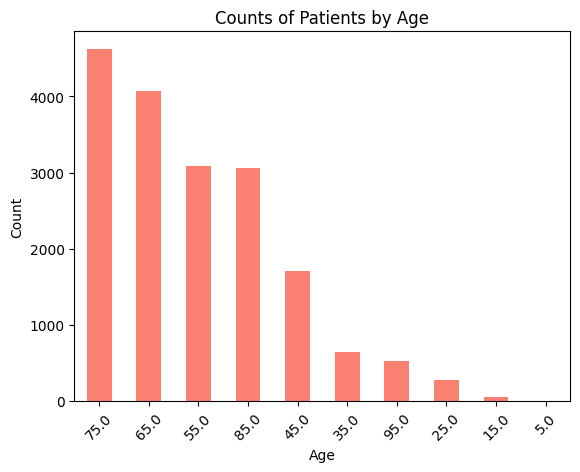

In [ ]:
age_count = numerical_col['age'].value_counts()
age_count.plot(kind='bar', color='salmon')
plt.title('Counts of Patients by Age')
plt.xlabel('Age')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [ ]:
#the percentage of the race type
new_diabetes.race.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

,proportion
race,
Caucasian,76.2%
AfricanAmerican,19.4%
Hispanic,1.9%
Other,1.7%
Asian,0.8%


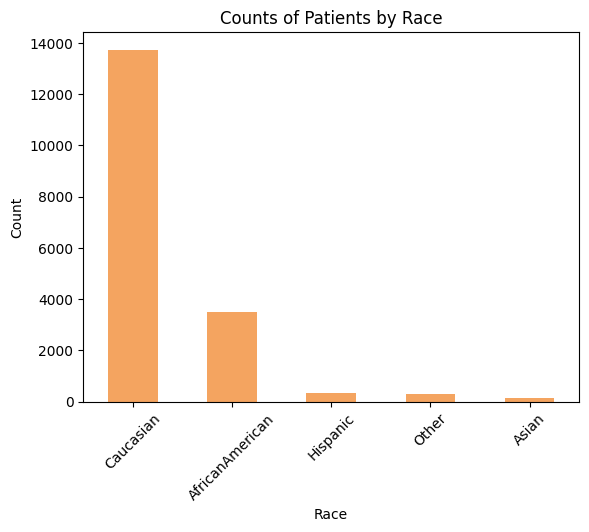

In [ ]:
race_count = new_diabetes['race'].value_counts()
race_count.plot(kind='bar', color='sandybrown')
plt.title('Counts of Patients by Race')
plt.xlabel('Race')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [ ]:
#the percentage of the gender type
new_diabetes.gender.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

,proportion
gender,
Female,53.5%
Male,46.5%


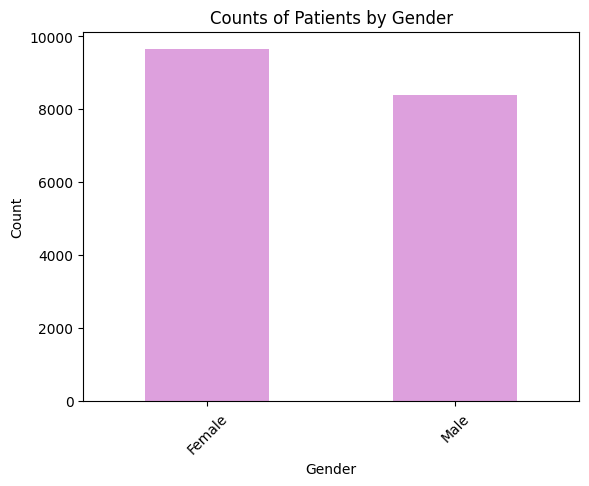

In [ ]:
gender_count = new_diabetes['gender'].value_counts()
gender_count.plot(kind='bar', color='plum')
plt.title('Counts of Patients by Gender')
plt.xlabel('Gender')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

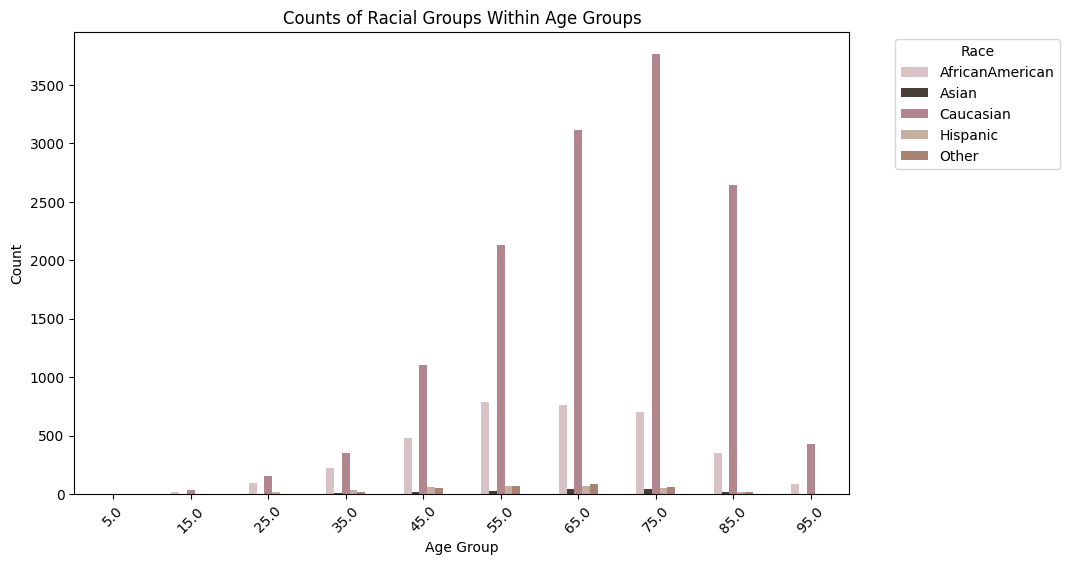

In [ ]:
#Visualise how much of each racial group exists within each age group

query = """
SELECT age, race, COUNT(*) AS count
FROM patients
GROUP BY age, race
ORDER BY count DESC
"""

df_1 = pd.read_sql_query(query, conn)

#ensuring that age will be sorted in ascending order for comprehension
df_1['age'] = pd.to_numeric(df_1['age'], errors='coerce')
df_1 = df_1.sort_values('age')

pivoted_df_1 = df_1.pivot(index='age', columns='race', values='count').fillna(0)

pivoted_df_1.plot(kind='bar', figsize=(10, 6), color=['#d8c2c6', '#473e36', '#b2868e', '#c7aea2', '#aa8472'])

plt.title('Counts of Racial Groups Within Age Groups')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

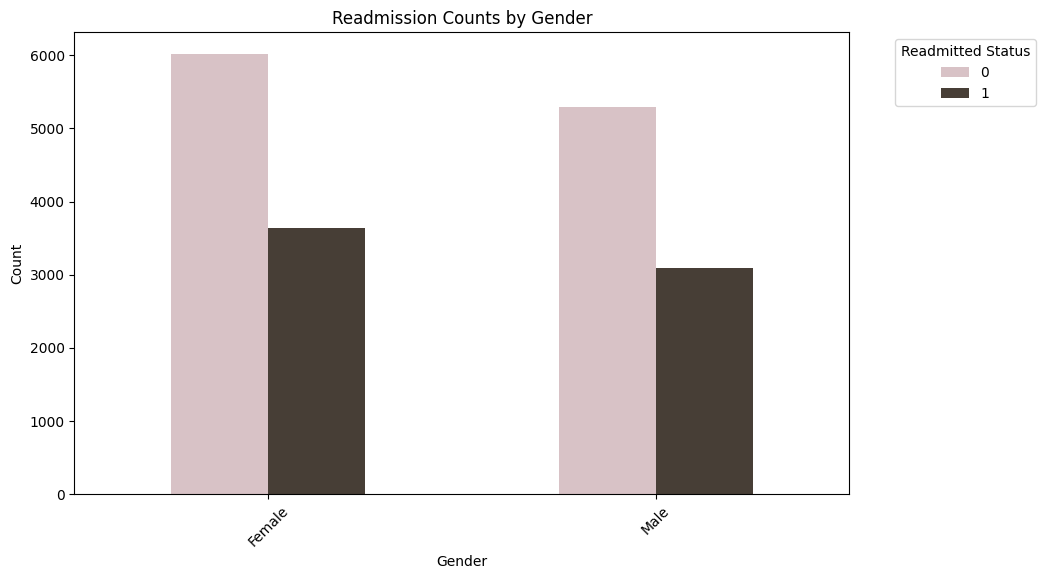

In [ ]:
#Show the count of readmissions by gender group
query = """
SELECT p.gender, e.readmitted, COUNT(*) AS count
FROM patients p
JOIN encounters e ON p.patient_nbr = e.patient_nbr
GROUP BY p.gender, e.readmitted
ORDER BY p.gender, e.readmitted;
"""

df_2 = pd.read_sql_query(query, conn)
pivoted_df_2 = df_2.pivot(index='gender', columns='readmitted', values='count').fillna(0)
pivoted_df_2.plot(kind='bar', figsize=(10, 6), color=['#d8c2c6', '#473e36'])

plt.title('Readmission Counts by Gender')
plt.xlabel('Gender')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Readmitted Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


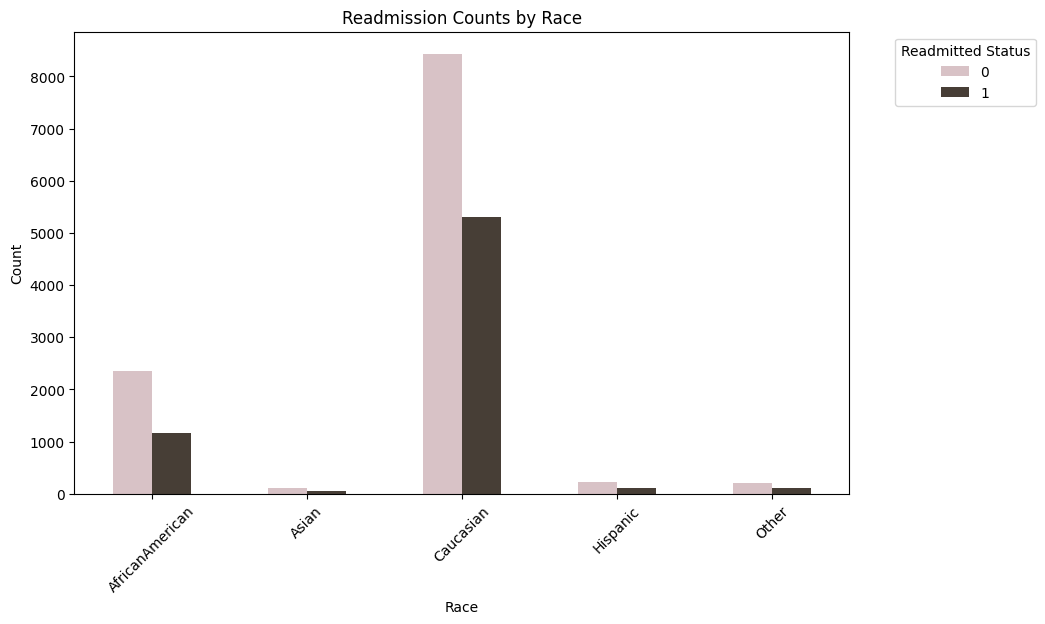

In [ ]:
#Show the count of readmissions by race group
query = """
SELECT p.race, e.readmitted, COUNT(*) AS count
FROM patients p
JOIN encounters e ON p.patient_nbr = e.patient_nbr
WHERE p.race IS NOT NULL AND p.race != ''
GROUP BY p.race, e.readmitted
ORDER BY p.race, e.readmitted;
"""

df_3 = pd.read_sql_query(query, conn)

pivoted_df_3 = df_3.pivot(index='race', columns='readmitted', values='count').fillna(0)

pivoted_df_3.plot(kind='bar', figsize=(10, 6), color=['#d8c2c6', '#473e36'])

plt.title('Readmission Counts by Race')
plt.xlabel('Race')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Readmitted Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

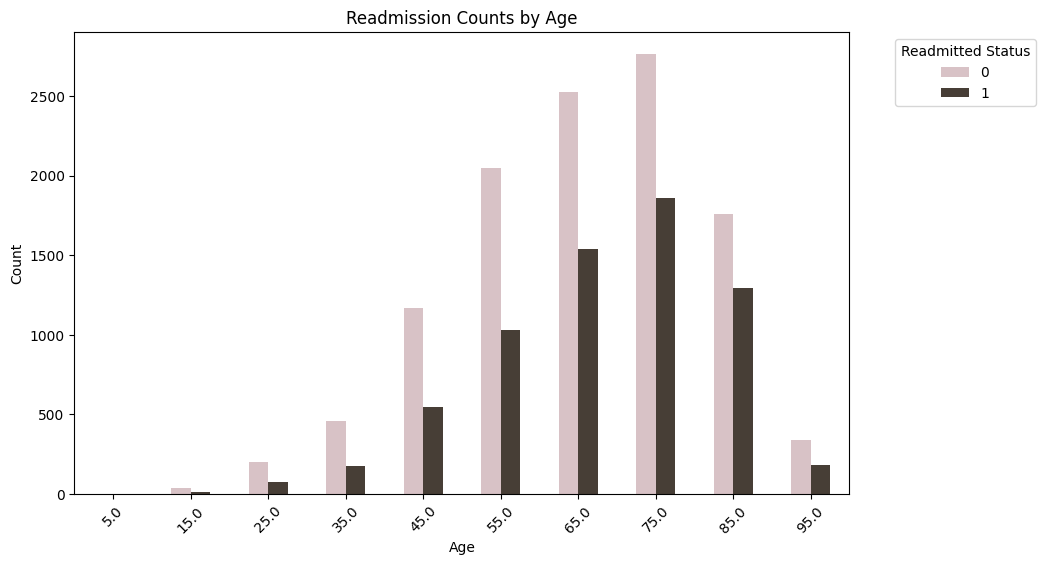

In [ ]:
#Show the count of readmissions by age group
query = """
SELECT p.age, e.readmitted, COUNT(*) AS count
FROM patients p
JOIN encounters e ON p.patient_nbr = e.patient_nbr
GROUP BY p.age, e.readmitted
ORDER BY p.age, e.readmitted;
"""

df_4 = pd.read_sql_query(query, conn)

#ensuring that age will be sorted in ascending order for comprehension
df_4['age'] = pd.to_numeric(df_4['age'], errors='coerce')
df_4 = df_4.sort_values('age')

pivoted_df_4 = df_4.pivot(index='age', columns='readmitted', values='count').fillna(0)

pivoted_df_4.plot(kind='bar', figsize=(10, 6), color=['#d8c2c6', '#473e36'])

plt.title('Readmission Counts by Age')
plt.xlabel('Age')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.legend(title='Readmitted Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Data Visualisation

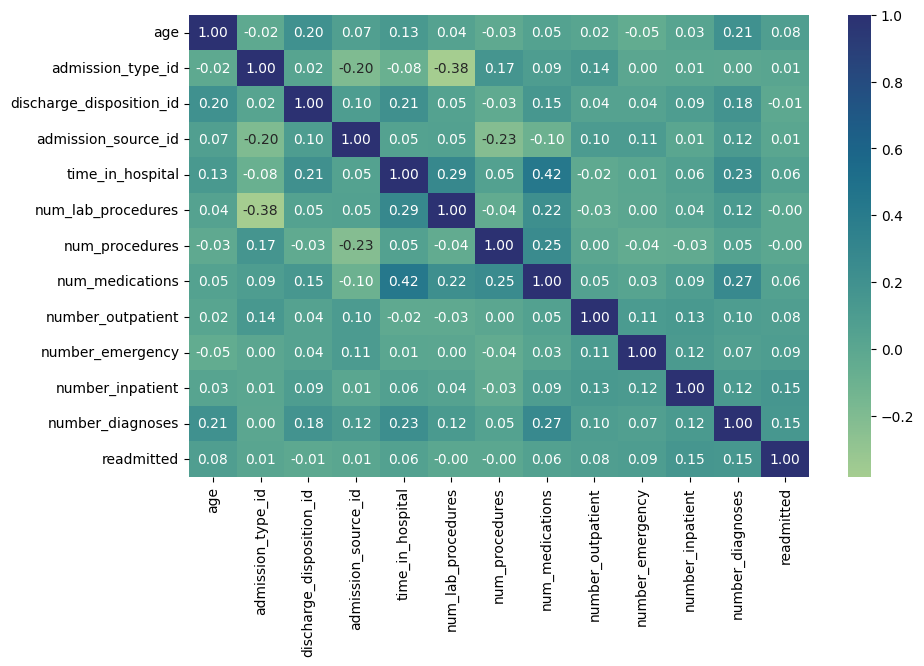

In [ ]:
#heatmap to show correlation co-efficients agsint the numerical columns

plt.figure(figsize=(10, 6))
c = numerical_col.corr()
sns.heatmap(c, cmap="crest", annot=True, fmt=".2f")
plt.show()

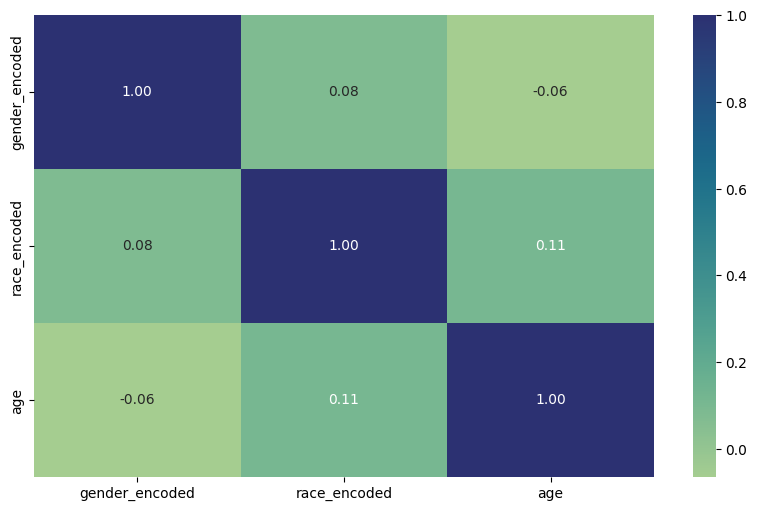

In [ ]:
#Looking at the correlation co-efficients between age, gender and race

#importing encoding libraries
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
#encode gender for data visualisation
new_diabetes['gender_encoded'] = label_encoder.fit_transform(new_diabetes['gender'])
#encode race for data visualisation
new_diabetes['race_encoded'] = label_encoder.fit_transform(new_diabetes['race'])
#plotting graph
plt.figure(figsize=(10, 6))
#defining columns for data visualisation
correlation_cols = ['gender_encoded', 'race_encoded', 'age']
data_corrs = new_diabetes[correlation_cols]
#finding their correlation co-efficients
c = data_corrs.corr()
#visualising the data
sns.heatmap(c, cmap="crest", annot=True, fmt=".2f")
plt.show()

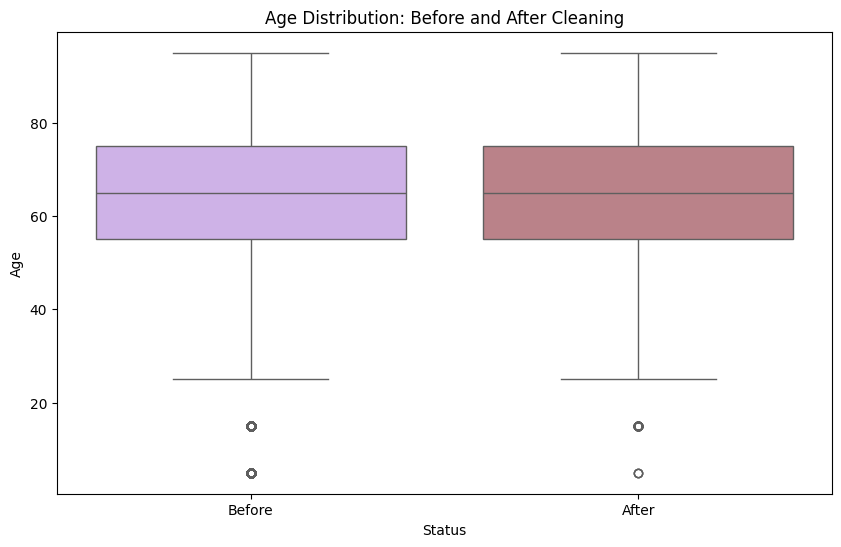

In [ ]:
#visualising data distribution for the age column
diabetes_df['Status'] = 'Before'
numerical_col['Status'] = 'After'

diabetes_df['age'] = pd.to_numeric(diabetes_df['age'], errors='coerce')
numerical_col['age'] = pd.to_numeric(new_diabetes['age'], errors='coerce')

#combining dataframes to compare
comparison_df = pd.concat([diabetes_df[['age', 'Status']], numerical_col[['age', 'Status']]])

plt.figure(figsize=(10, 6))
hex_colors = ['#cea9f0', '#c37982']
sns.boxplot(data=comparison_df, x='Status', y='age', palette=hex_colors).set(title='Age Distribution: Before and After Cleaning')
plt.xlabel('Status')
plt.ylabel('Age')
plt.show()

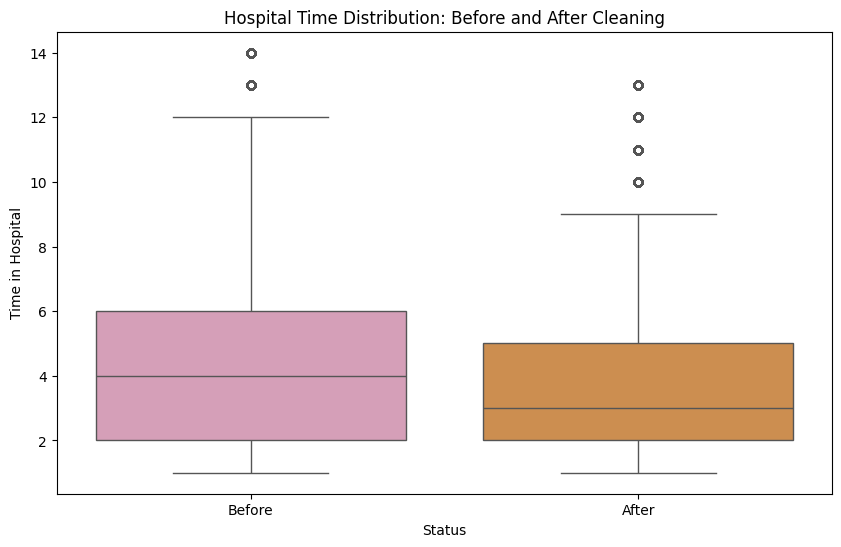

In [ ]:
diabetes_df['Status'] = 'Before'
numerical_col['Status'] = 'After'

#combining dataframes to compare
comparison_df = pd.concat([diabetes_df[['time_in_hospital', 'Status']], numerical_col[['time_in_hospital', 'Status']]])

plt.figure(figsize=(10, 6))
hex_colors = ['#de96b7', '#e18e3b']
sns.boxplot(data=comparison_df, x='Status', y='time_in_hospital', palette=hex_colors).set(title='Hospital Time Distribution: Before and After Cleaning')
plt.xlabel('Status')
plt.ylabel('Time in Hospital')
plt.show()

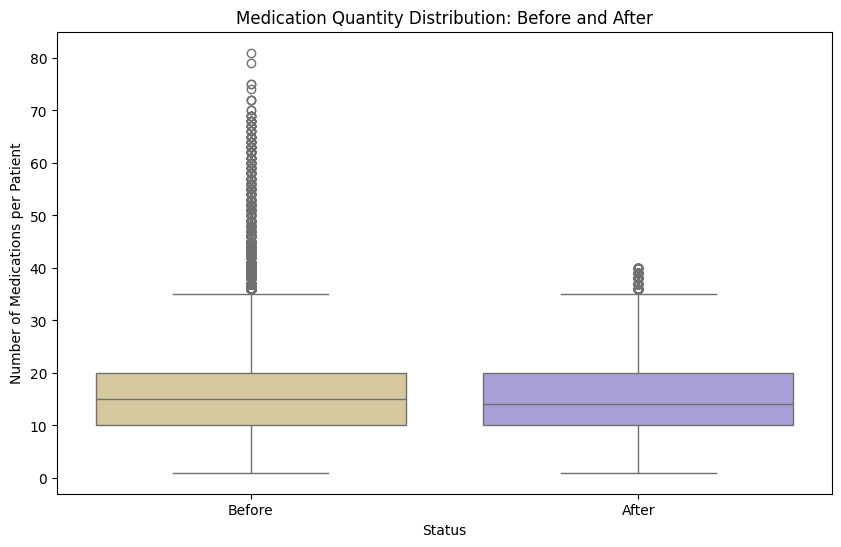

In [ ]:
#visualising data distribution in the column 'num_of_medications'

diabetes_df['Status'] = 'Before'
numerical_col['Status'] = 'After'

#combining dataframes to compare
comparison_df = pd.concat([diabetes_df[['num_medications', 'Status']], numerical_col[['num_medications', 'Status']]])

plt.figure(figsize=(10, 6))
hex_colors = ['#decc96', '#a196de']
sns.boxplot(data=comparison_df, x='Status', y='num_medications', palette=hex_colors).set(title='Medication Quantity Distribution: Before and After')
plt.xlabel('Status')
plt.ylabel('Number of Medications per Patient')
plt.show()